In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import torchvision
import torch
import os
import gc
import cv2
from tqdm import tqdm

from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as A
import itertools
import timm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from torchvision.models import ResNet50_Weights, resnet50
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

from pathlib import Path
from PIL import Image
import torch.nn.functional as F

RS = 42
TRAIN_DIR = Path('train_images/')
TEST_DIR = Path('test_images/')
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
train_df = pd.read_csv('train_dataset.csv')
train_df.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [3]:
enot = pd.read_csv('ExpertAnnotations.tsv', delim_whitespace=True, header=None)
enot.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [4]:
crot = pd.read_csv('CrowdAnnotations.tsv', delim_whitespace=True, header=None)
crot.head()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [5]:
tesq = pd.read_csv('test_queries.csv', sep='|', index_col=0)
tesq.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [6]:
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.name for path in train_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

## 1. EDA


In [7]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

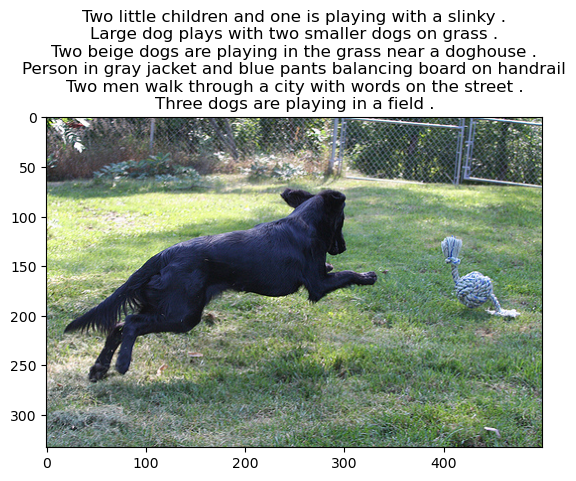

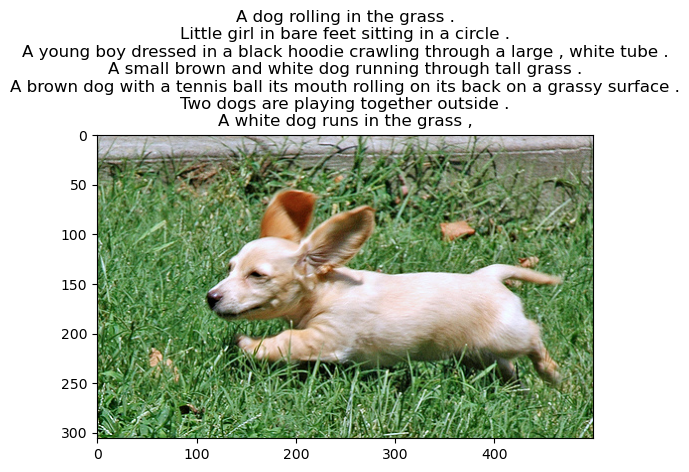

In [8]:
for file in train_files[5:7]:
    image = load_image(file)
    name = train_df.loc[train_df['image'] == file.__str__()[13:]]

    _ = '\n'.join(list(name['query_text']))
    plt.imshow(image)
    plt.title(_)
    plt.show()

### Merging data on names

In [9]:
queries = train_df[['query_id', 'query_text']].drop_duplicates()

In [10]:
queries['query_id'] = queries['query_id'].str.rstrip('#2')

In [11]:
queries = queries.reset_index(drop=True)

## 3. Visual Encoder

In [12]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Linear(2048, 768)
image_encoder = resnet50

## 4. Text Encoder

In [13]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig.from_pretrained('distilbert-base-cased',
                                                                                 output_hidden_states=True))
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [14]:
text_encoder = TextEncoder()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Main model

In [15]:
queries.to_csv('my_data.csv')

In [16]:
my_data = pd.read_csv('my_data.csv', index_col=0)

### Dataset & DataLoader

In [17]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms, image_path='train_images'):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """
        self.image_path = image_path
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{self.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(224, 224, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(224, 224, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [18]:
dataset = CLIPDataset(my_data['query_id'], my_data['query_text'], tokenizer, transforms=get_transforms('train'))

dataloader = DataLoader(dataset, batch_size=32)

#### sanity check

In [19]:
for i in enumerate(dataloader):
    text_features = text_encoder(
            input_ids=i[1]["input_ids"], attention_mask=i[1]["attention_mask"]
        )
    image_feature = image_encoder(i[1]["image"])
    break

In [20]:
image_feature.size()

torch.Size([32, 768])

In [21]:
text_features.size()

torch.Size([32, 768])

### Projection Head

In [22]:
class ProjectionHead(nn.Module):
    def __init__(self,
        embedding_dim,
        projection_dim=512,
        dropout=.1
    ):
        super().__init__()
        self.projection = nn.Linear(768, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [23]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_projection = ProjectionHead(embedding_dim=512)
        self.text_projection = ProjectionHead(embedding_dim=512)

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_features = self.image_projection(image_features)
        text_features = self.text_projection(text_features)

        # Calculating the Loss
        logits = text_features @ image_features.T
        images_similarity = image_features @ image_features.T
        texts_similarity = text_features @ text_features.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2, dim=-1)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

### Training & loss functions

In [24]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [25]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [26]:
model = CLIPModel().to(device)
params = [
        {"params": model.image_encoder.parameters(), "lr": 1e-4},
        {"params": model.text_encoder.parameters(), "lr": 1e-5},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": 1e-5, "weight_decay": 1e-3}
    ]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min")
step = "epoch"

In [27]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

### Train & eval time

In [28]:
train_set = CLIPDataset(my_data[:700]['query_id'], 
                        my_data[:700]['query_text'], 
                        tokenizer, 
                        transforms=get_transforms('train'))
val_set = CLIPDataset(my_data[700:].reset_index(drop=True)['query_id'],
                      my_data[700:].reset_index(drop=True)['query_text'],
                      tokenizer, 
                      transforms=get_transforms('val'))

In [29]:
train_loader = DataLoader(train_set, batch_size=32)
valid_loader = DataLoader(val_set, batch_size=32)

In [30]:
best_loss = float('inf')
for epoch in range(8):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

Epoch: 1


100%|██████████| 9/9 [00:01<00:00,  4.60it/s, valid_loss=19.6]


Saved Best Model!
Epoch: 2


100%|██████████| 9/9 [00:01<00:00,  4.71it/s, valid_loss=12.1]


Saved Best Model!
Epoch: 3


100%|██████████| 9/9 [00:01<00:00,  4.70it/s, valid_loss=9.05]


Saved Best Model!
Epoch: 4


100%|██████████| 9/9 [00:02<00:00,  4.48it/s, valid_loss=7.58]


Saved Best Model!
Epoch: 5


100%|██████████| 9/9 [00:02<00:00,  4.35it/s, valid_loss=7.61]


Epoch: 6


100%|██████████| 9/9 [00:01<00:00,  4.66it/s, valid_loss=7.4] 


Saved Best Model!
Epoch: 7


100%|██████████| 9/9 [00:01<00:00,  4.84it/s, valid_loss=7.54]


Epoch: 8


100%|██████████| 9/9 [00:01<00:00,  4.54it/s, valid_loss=7.81]


## 7. Test


In [31]:
def get_image_embeddings(valid_loader, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    valid_loader = valid_loader
    
    model = CLIPModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [32]:
placeholder_test = tesq.loc[tesq['image']==tesq['query_id'].str.rstrip('#2')] 
placeholder_test = placeholder_test.reset_index(drop=True)

In [33]:
test_set = CLIPDataset(placeholder_test['image'], placeholder_test['query_text'], 
                       tokenizer, transforms=get_transforms('train'), image_path='test_images')

In [34]:
test_loader = DataLoader(test_set, batch_size=16)
model, image_embeddings = get_image_embeddings(test_loader, "best.pt")

100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


In [35]:
def find_matches(query, model=model, image_embeddings=image_embeddings, image_filenames=placeholder_test['image'].values):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    values, indices = torch.topk(dot_similarity.squeeze(0), 1)
    image = cv2.imread(f"{'test_images'}/{image_filenames[int(indices.detach())]}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(query)
    plt.imshow(image)
    plt.show()
    print('----------------------')

In [36]:
random_query = tesq.sample(5, random_state=43)

A large tan dog sits on a grassy hill .


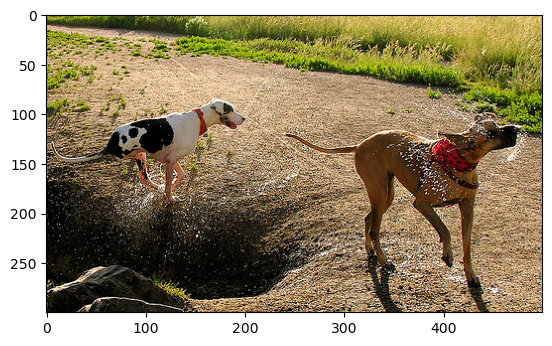

----------------------
A white dog runs on brown grass .


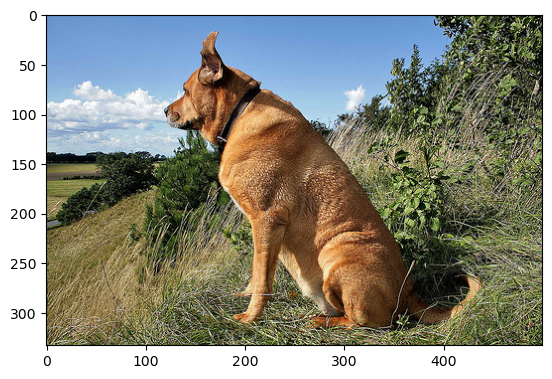

----------------------
A group of three females and one male dressed in costume


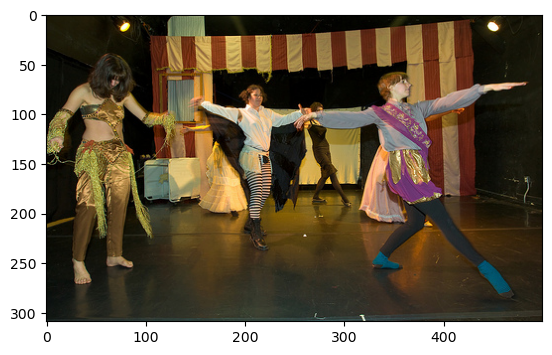

----------------------
A playground with two children and an adult .


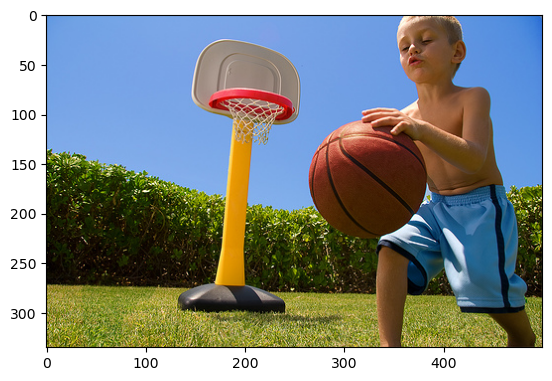

----------------------
A boy in a blue shirt and white pants stands on the edge of a lake in a town with a church in the background .


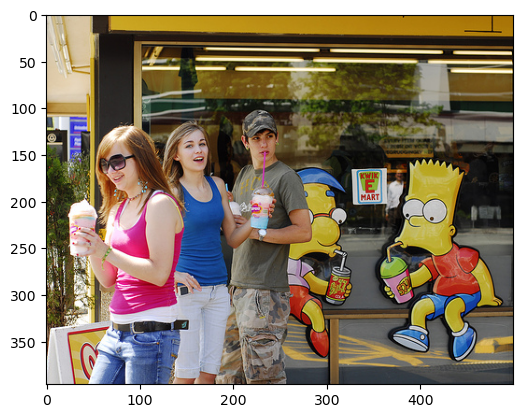

----------------------


In [37]:
for i in random_query['query_text']:
    find_matches(i)